<a href="https://colab.research.google.com/github/shakasom/geospatial-tips/blob/master/Three_tips_geospatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Five useful tips on how to effectively use Location data in Python

In [1]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet

# Folium 
!pip install folium

# Rasterio
!pip install Rasterio

# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet


In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt


import folium
import rasterio as rio

import pysal
from pysal.lib  import weights
from pysal.explore import  esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster


/usr/local/lib/python3.6/dist-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


## 1 - Convert your data to GeoDataFrame

In [3]:
#Read in Pandas
df = pd.read_csv('https://query.data.world/s/6joi7hjgjmwifhl2clpldwm36xmvmx',usecols=['OBJECTID','CCN', 'REPORTDATETIME', 'SHIFT', 'OFFENSE','METHOD','DISTRICT','X', 'Y'])
#df = pd.read_csv('https://query.data.world/s/6joi7hjgjmwifhl2clpldwm36xmvmx')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs={"init":"epsg:4326"})
gdf.head()

,X,Y,OBJECTID,CCN,REPORTDATETIME,SHIFT,OFFENSE,METHOD,DISTRICT,geometry
0,-76.946978,38.893354,182201,16015685,2016-01-31T23:17:56.000Z,MIDNIGHT,ROBBERY,GUN,SIXTH,POINT (-76.94698 38.89335)
1,-77.038520,38.904251,182202,16015745,2016-02-01T00:00:00.000Z,MIDNIGHT,HOMICIDE,KNIFE,SECOND,POINT (-77.03852 38.90425)
2,-77.026528,38.898317,182203,16015704,2016-02-01T01:15:34.000Z,MIDNIGHT,ASSAULT W/DANGEROUS WEAPON,OTHERS,FIRST,POINT (-77.02653 38.89832)
3,-77.027916,38.939215,182204,16015736,2016-02-01T01:35:52.000Z,MIDNIGHT,THEFT F/AUTO,OTHERS,FOURTH,POINT (-77.02792 38.93921)
4,-76.970423,38.867778,182205,16015695,2016-02-01T02:17:26.000Z,MIDNIGHT,THEFT F/AUTO,OTHERS,SEVENTH,POINT (-76.97042 38.86778)


In [4]:
gdf.shape

(15853, 10)

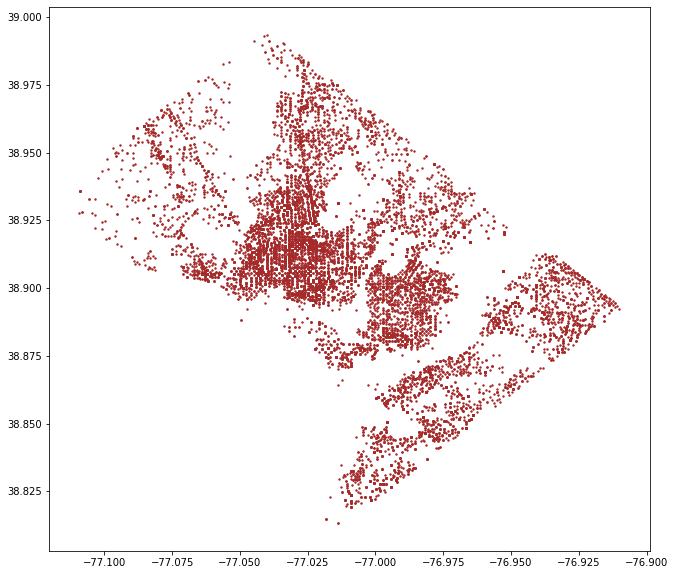

In [5]:
fig, ax = plt.subplots(figsize=(12,10))
gdf.plot(ax=ax, markersize=2, color="brown")
plt.show()

In [6]:
m = folium.Map(
    location=[38.904251, -77.038520],
    zoom_start=12,
    tiles='Stamen Terrain'
)
folium.GeoJson(
    gdf.sample(1000),
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(m)
m

## 2. Know your Coordinates

In [7]:
center = Point( [-77.036618, 38.907155])

center_gdf = gpd.GeoDataFrame(gpd.GeoSeries(center), crs={"init":"epsg:4326"})
center_gdf.rename({0:'geometry'}, axis=1, inplace=True)
center_gdf

,geometry
0,POINT (-77.03662 38.90716)


In [8]:
gdf['distance_center'] = gdf.geometry.apply(lambda g: center_gdf.distance(g))
gdf.head()

,X,Y,OBJECTID,CCN,REPORTDATETIME,SHIFT,OFFENSE,METHOD,DISTRICT,geometry,distance_center
0,-76.946978,38.893354,182201,16015685,2016-01-31T23:17:56.000Z,MIDNIGHT,ROBBERY,GUN,SIXTH,POINT (-76.94698 38.89335),0.090697
1,-77.038520,38.904251,182202,16015745,2016-02-01T00:00:00.000Z,MIDNIGHT,HOMICIDE,KNIFE,SECOND,POINT (-77.03852 38.90425),0.003472
2,-77.026528,38.898317,182203,16015704,2016-02-01T01:15:34.000Z,MIDNIGHT,ASSAULT W/DANGEROUS WEAPON,OTHERS,FIRST,POINT (-77.02653 38.89832),0.013413
3,-77.027916,38.939215,182204,16015736,2016-02-01T01:35:52.000Z,MIDNIGHT,THEFT F/AUTO,OTHERS,FOURTH,POINT (-77.02792 38.93921),0.033220
4,-76.970423,38.867778,182205,16015695,2016-02-01T02:17:26.000Z,MIDNIGHT,THEFT F/AUTO,OTHERS,SEVENTH,POINT (-76.97042 38.86778),0.077022


In [0]:
# Reproject this
gdf_proj  = gdf.to_crs({'init': 'epsg:8103'})
center_gdf_proj = center_gdf.to_crs({'init': 'epsg:8103'})

In [10]:
gdf_proj['distance_center_m'] = gdf_proj.geometry.apply(lambda g: center_gdf_proj.distance(g))
gdf_proj.head()

,X,Y,OBJECTID,CCN,REPORTDATETIME,SHIFT,OFFENSE,METHOD,DISTRICT,geometry,distance_center,distance_center_m
0,-76.946978,38.893354,182201,16015685,2016-01-31T23:17:56.000Z,MIDNIGHT,ROBBERY,GUN,SIXTH,POINT (1085857.606 -387727.236),0.090697,8016.311934
1,-77.038520,38.904251,182202,16015745,2016-02-01T00:00:00.000Z,MIDNIGHT,HOMICIDE,KNIFE,SECOND,POINT (1077736.180 -387492.473),0.003472,366.300499
2,-77.026528,38.898317,182203,16015704,2016-02-01T01:15:34.000Z,MIDNIGHT,ASSAULT W/DANGEROUS WEAPON,OTHERS,FIRST,POINT (1078861.440 -388025.820),0.013413,1329.694736
3,-77.027916,38.939215,182204,16015736,2016-02-01T01:35:52.000Z,MIDNIGHT,THEFT F/AUTO,OTHERS,FOURTH,POINT (1078182.108 -383482.934),0.033220,3679.534376
4,-76.970423,38.867778,182205,16015695,2016-02-01T02:17:26.000Z,MIDNIGHT,THEFT F/AUTO,OTHERS,SEVENTH,POINT (1084166.457 -390829.265),0.077022,7300.089198


 ## 3. Enrich your data with Spatial join

In [11]:
poverty = gpd.read_file("https://opendata.arcgis.com/datasets/5a357128cf2b490e9c716e03dcc03a3e_62.geojson", usecols=["OBJECTID","STATEFP10", "COUNTYFP10", "TRACTCE10", "TOTAL_POP", "UNEMPLOYME", "POVERTY_RA", "MEDIAN_INC", "geometry"])
poverty = poverty[["OBJECTID","STATEFP10", "COUNTYFP10", "TRACTCE10", "TOTAL_POP", "UNEMPLOYME", "POVERTY_RA", "MEDIAN_INC", "geometry"]]
poverty = poverty[poverty["STATEFP10"] == "11"]
poverty.head()

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,TOTAL_POP,UNEMPLOYME,POVERTY_RA,MEDIAN_INC,geometry
606,830,11,001,007403,3412,0.225,0.369,27652,"POLYGON ((-76.98060 38.84682, -76.98066 38.846..."
607,831,11,001,007100,3270,0.188,0.377,72941,"POLYGON ((-76.98367 38.87957, -76.98508 38.880..."
608,832,11,001,007200,3485,0.067,0.125,91458,"POLYGON ((-76.99267 38.87025, -76.99257 38.870..."
609,833,11,001,007304,3708,0.268,0.432,23867,"POLYGON ((-76.98280 38.84619, -76.98293 38.846..."
610,834,11,001,007401,2524,0.256,0.573,15393,"POLYGON ((-76.99145 38.86583, -76.99110 38.866..."


In [12]:
poverty.crs

{'init': 'epsg:4326'}

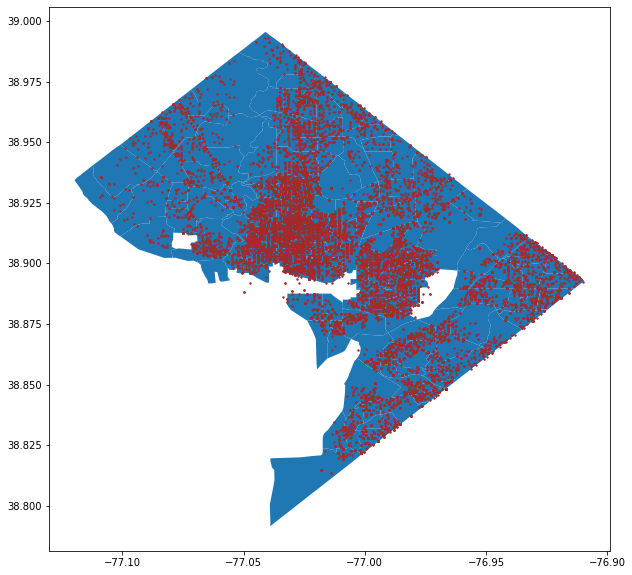

In [14]:
fig, ax = plt.subplots(figsize=(12,10))
poverty.plot(column="COUNTYFP10", ax=ax)
gdf.plot(markersize=2, color="brown", ax=ax)
plt.show()

In [15]:
spatial_join_points = gpd.sjoin(gdf, poverty, op="within")
spatial_join_points.head()

,X,Y,OBJECTID_left,CCN,REPORTDATETIME,SHIFT,OFFENSE,METHOD,DISTRICT,geometry,distance_center,index_right,OBJECTID_right,STATEFP10,COUNTYFP10,TRACTCE10,TOTAL_POP,UNEMPLOYME,POVERTY_RA,MEDIAN_INC
0,-76.946978,38.893354,182201,16015685,2016-01-31T23:17:56.000Z,MIDNIGHT,ROBBERY,GUN,SIXTH,POINT (-76.94698 38.89335),0.090697,942,903,11,001,009603,2735,0.179,0.159,39268
166,-76.946264,38.891894,181735,16012050,2016-01-24T22:26:31.000Z,EVENING,THEFT F/AUTO,OTHERS,SIXTH,POINT (-76.94626 38.89189),0.091634,942,903,11,001,009603,2735,0.179,0.159,39268
224,-76.952545,38.893284,182719,16019233,2016-02-07T04:58:17.000Z,MIDNIGHT,BURGLARY,OTHERS,SIXTH,POINT (-76.95255 38.89328),0.085209,942,903,11,001,009603,2735,0.179,0.159,39268
333,-76.949628,38.894481,181822,16012918,2016-01-26T21:33:13.000Z,EVENING,ROBBERY,OTHERS,SIXTH,POINT (-76.94963 38.89448),0.087908,942,903,11,001,009603,2735,0.179,0.159,39268
335,-76.950978,38.892680,181824,16012930,2016-01-26T21:54:22.000Z,EVENING,THEFT F/AUTO,OTHERS,SIXTH,POINT (-76.95098 38.89268),0.086855,942,903,11,001,009603,2735,0.179,0.159,39268


# End